In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import os, sys
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.models_v1 import SimpleCNN

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
train_dir = r"D:\Collaborative_CNN_Team_09\data\training_set"
test_dir  = r"D:\Collaborative_CNN_Team_09\data\test_set"

img_size = 128
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Classes:", train_data.classes)
print("Train size:", len(train_data))
print("Test size:", len(test_data))

Classes: ['cats', 'dogs']
Train size: 8005
Test size: 2023


In [4]:
model = SimpleCNN()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


SimpleCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



In [12]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.detach().cpu().tolist())
            all_labels.extend(labels.detach().cpu().tolist())

            pbar.set_postfix({"loss": round(loss.item(), 4)})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

In [16]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return running_loss / len(dataloader), accuracy, f1

In [18]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return running_loss / len(dataloader), accuracy, f1


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [22]:
NUM_EPOCHS = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

import os
os.makedirs("models", exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    train_loss, train_acc, train_f1 = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc, val_f1 = evaluate(
        model, test_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f" Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f" Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    save_path = f"models/epoch_{epoch}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Saved model → {save_path}")

torch.save(model.state_dict(), "models/final_model.pth")
print("\nFinal model saved → models/final_model.pth")



Epoch 1/5


 Train Loss: 0.5963 | Acc: 0.6743 | F1: 0.6743
 Val   Loss: 0.5604 | Acc: 0.7123 | F1: 0.7121
Saved model → models/epoch_1.pth

Epoch 2/5


 Train Loss: 0.5080 | Acc: 0.7493 | F1: 0.7493
 Val   Loss: 0.5005 | Acc: 0.7479 | F1: 0.7477
Saved model → models/epoch_2.pth

Epoch 3/5


 Train Loss: 0.4570 | Acc: 0.7863 | F1: 0.7862
 Val   Loss: 0.4914 | Acc: 0.7637 | F1: 0.7632
Saved model → models/epoch_3.pth

Epoch 4/5


 Train Loss: 0.4003 | Acc: 0.8141 | F1: 0.8141
 Val   Loss: 0.4837 | Acc: 0.7647 | F1: 0.7645
Saved model → models/epoch_4.pth

Epoch 5/5


 Train Loss: 0.3339 | Acc: 0.8500 | F1: 0.8500
 Val   Loss: 0.5177 | Acc: 0.7756 | F1: 0.7754
Saved model → models/epoch_5.pth

Final model saved → models/final_model.pth


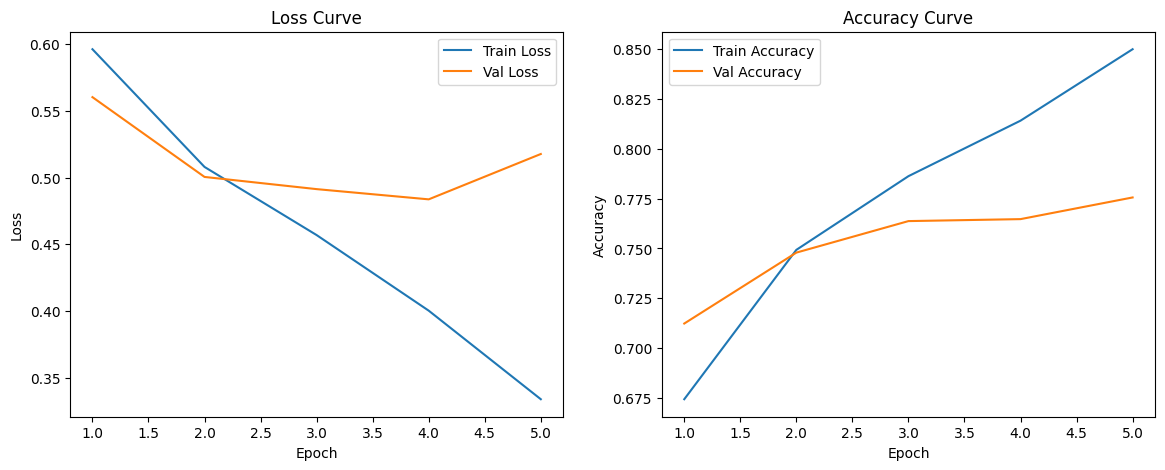

In [23]:
epochs_range = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

# ---- Loss Plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# ---- Accuracy Plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


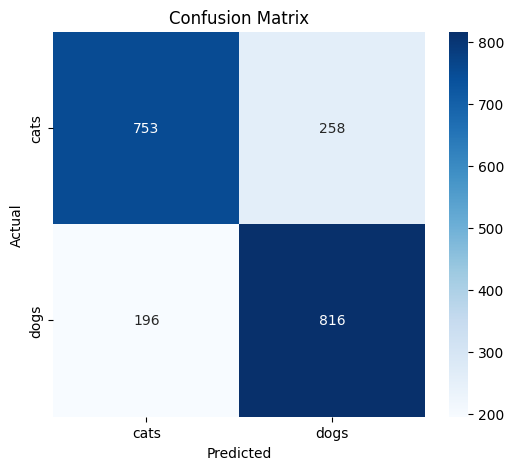

In [24]:
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_labels, all_preds


labels, preds = get_all_preds(model, test_loader, device)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_loader.dataset.classes,
            yticklabels=train_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
from PIL import Image

def predict_image(path, model, device, transform, class_names):
    model.eval()

    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_t)
        _, pred = torch.max(outputs, 1)

    print(f"Prediction: {class_names[pred.item()]}")


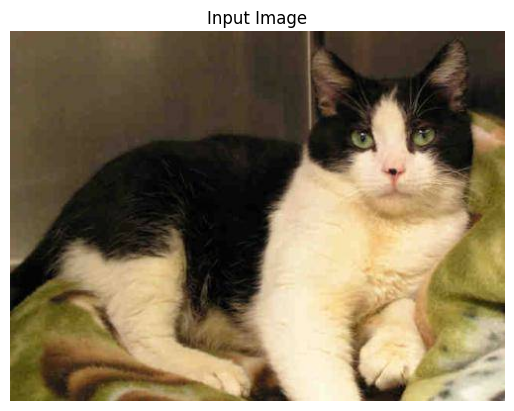

Prediction: cats


In [28]:
predict_image(
    r"D:\Collaborative_CNN_Team_09\data\test_set\cats\cat.4062.jpg",
    model,
    device,
    transform,
    train_data.classes  # ['cats', 'dogs']
)
